In [14]:
# General.
import os
import glob
import datetime
import math
import random
import re
from tqdm import tqdm

# Data manipulation.
import pandas as pd
import numpy as np
import geopandas as gpd
from libpysal import weights
import networkx as nx
import matplotlib.pyplot as plt

# Torch.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# Helper functions.
from notebooks.lstm_helper_fns import *

In [15]:
# List package versions.
!pip freeze

aiohappyeyeballs==2.5.0
aiohttp==3.11.13
aiosignal==1.3.2
albucore==0.0.23
albumentations==2.0.5
annotated-types==0.7.0
appnope==0.1.4
asttokens==3.0.0
attrs==25.1.0
beautifulsoup4==4.13.3
certifi==2025.1.31
charset-normalizer==3.4.1
cmdstanpy==1.2.5
comm==0.2.2
contourpy==1.3.1
cycler==0.12.1
debugpy==1.8.12
decorator==5.1.1
dicom==0.9.9.post1
executing==2.2.0
filelock==3.17.0
fonttools==4.55.8
frozenlist==1.5.0
fsspec==2025.2.0
geopandas==1.0.1
holidays==0.69
idna==3.10
imageio==2.37.0
importlib_resources==6.5.2
ipykernel==6.29.5
ipython==8.32.0
jedi==0.19.2
Jinja2==3.1.5
joblib==1.4.2
jupyter_client==8.6.3
jupyter_core==5.7.2
kiwisolver==1.4.8
lazy_loader==0.4
libpysal==4.12.1
MarkupSafe==3.0.2
matplotlib==3.10.0
matplotlib-inline==0.1.7
mpmath==1.3.0
multidict==6.1.0
nest-asyncio==1.6.0
networkx==3.4.2
numpy==2.2.2
opencv-python==4.11.0.86
opencv-python-headless==4.11.0.86
packaging==24.2
pandas==2.2.3
parso==0.8.4
patsy==1.0.1
pexpect==4.9.0
pillow==11.1.0
platformdirs==4.3.6
prom

In [16]:
src = os.getcwd()


In [17]:
class DailyCaseDataset(Dataset):
    """
    The tabular form of the counties-daily case data for the LSTM.
    Samples are in the form: input = window_size-7 days of cases, label = 7 days of cases.

    Args:
    - df: (pd.DataFrame) a num_counties, num_dates dataframe, containing float values.
    - window: (int) an integer of the entire window used as input and label - e.g window=35
    will give an input size of 35-7=28, with the label size always being 7.

    Returns a dictionary containing the input and label (stored under 'input' and 'label')
    of which the model is trained on 
    """
    def __init__(self, df, in_len, pred_len):
        self.data = df.to_numpy() # 2D array. 
        self.window = in_len + pred_len
        self.in_len = in_len
        self.pred_len = pred_len
        self.num_rows = self.data.shape[0]
        self.num_cols = self.data.shape[1]

        # Each row can provide (num_cols - window + 1) valid windows.
        self.samples_per_row = self.num_cols - self.window + 1
        self.data_size = self.num_rows * self.samples_per_row

    def __len__(self):
        # Ensure that we only allow indices that yield a full window of 'window' elements.
        return self.data_size
        
    def __getitem__(self, idx):
        # Map 1D index to a 2D index.
        row = idx // self.samples_per_row
        col = idx % self.samples_per_row

        # Window of the data for a given row.
        data = torch.tensor(self.data[row, col:col+self.window], dtype=torch.float32)
        
        # Extract the label as the last 7 elements and the input as the preceding elements.
        label = data[-self.in_len:]
        input = data[:-self.pred_len]
            
        return {'label': label, 
                'input': input}


In [18]:
# Read in data.
dftrain = pd.read_csv(os.path.join(src, 'data/processed/LSTM/TRAIN_SCALED.csv'))
dfval = pd.read_csv(os.path.join(src, 'data/processed/LSTM/VAL_SCALED.csv'))
dftest = pd.read_csv(os.path.join(src, 'data/processed/LSTM/TEST_SCALED.csv'))

non_numeric_cols = ['County Name', 'State', 'countyFIPS']
dftrain.drop(non_numeric_cols, axis=1, inplace=True)
dfval.drop(non_numeric_cols, axis=1, inplace=True)
dftest.drop(non_numeric_cols, axis=1, inplace=True)

# print(f"Number of training samples with window=35: {len(DailyCaseDataset(dftrain, window=35))}")
# print(f"Number of validation samples with window=35: {len(DailyCaseDataset(dfval, window=35))}")
# print(f"Number of testing samples with window=35: {len(DailyCaseDataset(dftest, window=35))}")

In [19]:
class CFG:
    # Settings.
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_epochs = 25

In [20]:
class LSTM(nn.Module):
    """
    The LSTM architecture used to determine the correct hyperparameters, 
    containing options to add dropout, attention or make the model bidirectional.
    
    Args:
    - hidden_size, num_layers, input_size: int.
    Optional: 
    - dropout, bidirectional: bool.
    - num_heads: int.
    """
    def __init__(self, 
                 hidden_size, 
                 num_layers, 
                 input_size, 
                 pred_size,
                 bidirectional=False, 
                 dropout=False, 
                 num_heads=0):
        super(LSTM, self).__init__()
        # input_size should be the length of the input sequence (i.e 21, 28, 35 etc.)
        # hidden_size is 64-128.
        # num_layers is either 1 or 2.
        # bi-lstm and attention leads to overfitting with nl 2 and hs 128,

        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            bias=True, 
                            batch_first=True, # Meaning shapes should lead with batch_size.
                            dropout=0.0, # Does nothing with num_layers = 1.
                            bidirectional=bidirectional,
                            proj_size=0, 
                            dtype=None)
        
        # Determines whether dropout or attention is used in the model.
        self.dropoutbool = dropout
        self.num_heads = num_heads

        fc_in = hidden_size * 2 if bidirectional else hidden_size # Bidirectional has double hidden size.

        if num_heads > 0: # Raises error if num_heads=0.
            self.multihead_attn = nn.MultiheadAttention(embed_dim=fc_in, num_heads=num_heads, batch_first=True)

        self.dropout = nn.Dropout(p=0.5)

        # Fully connected layer - 
        self.fc1 = nn.Linear(in_features=fc_in,
                            out_features=pred_size,
                            bias=True)
        

    def forward(self, x):
        # x: (batch_size, seq_len, input_size).
        x, _ = self.lstm(x) # (batch_size, seq_len, fc_in).
        
        # Apply attention where query, key, and value are the LSTM outputs.
        if self.num_heads > 0:
            x, attn_weights = self.multihead_attn(x, x, x)
        
        # Apply dropout.
        if self.dropoutbool:
            x = self.dropout(x)
            
        return self.fc1(F.relu(x)) # (batch_size, pred_size).


In [21]:
@torch.no_grad
def test(model, dl, loss_fn, show_res=False):
    """
    Args:
    - model: torch.nn.Module.
    - dl: torch.utils.data.DataLoader.
    - loss_fn: torch.nn NOT torch.Functional type.
    - show_res (optional): True, show a random set of 9 results.

    Returns the average loss of the model on the dataloader.
    """
    model.eval()
    total_loss = 0.0
    r = random.randint(0, len(dl))
    for i, data in enumerate(dl):
        input, label = data[f'input'].to(CFG.device), data['label'].to(CFG.device)

        output = model(input)
        loss = loss_fn(output, label)
        total_loss += loss.item()
            
        # Show a random sample.
        if show_res and i == r:
            rrow = random.randint(1, input.shape[0]-10) # Random sample from batch.
            l, o = detach_np(label[rrow:rrow+9]), detach_np(output[rrow:rrow+9])
            print(f"Validation/test predictions")
            display_preds(label=l, output=o, loss=None)#loss=loss_fn(l, o).item())
    
    return total_loss / (len(dl)) # Average test loss over all batches.

In [22]:
def train(model, train_dl, val_dl, hparams, save_loc, show_res=False, show_epoch_acc=True):
    """
    Args:
    - model: torch.nn.Module.
    - train_dl: torch.utils.data.DataLoader.
    - val_dl: torch.utils.data.DataLoader, if entered as None, then validation is skipped.
    - hparams: dict consisting of keys: op, lf, is, bs, lr, hs and nl.
    - save_loc: str containing the save paths of the model weights.
    - show_res (optional): True, display a subset of results from random batch.
    - show_epoch_acc (optional): True, display the progress of the training (and optionally 
    the validation) accuracies of the model every epoch.

    Returns:
    - tr_losses, val_losses: np.array containing the losses for each epoch in training and validation.
    OR
    - tr_losses: np.array if val_dl == None.
    """
    optimizer, loss_fn, input_size = hparams['op'], hparams['lf'], hparams['is']
    batch_size, lr, hs, num_layers = hparams['bs'], hparams['lr'], hparams['hs'], hparams['nl']

    # Create a new folder for weights based on the existing folders. e.g. LSTM01 makes LSTM02.
    os.makedirs(save_loc, exist_ok=True)
    save_loc = create_weights_folder(save_loc)

    # Random batch to display samples from.
    r = random.randint(0, len(train_dl)-1)

    tr_losses = np.array([])
    val_losses = np.array([])

    for i, e in enumerate(range(1, CFG.num_epochs+1)):
        model.train() # Renew training status after validation.
        epoch_loss = 0
        print(f"{'-' * 20} \nEpoch {e}\n {'-' * 20}")

        for i, data in tqdm(enumerate(train_dl), total=len(train_dl)):
            input, label = data['input'].to(CFG.device), data['label'].to(CFG.device)

            output = model(input)
            loss = loss_fn(output, label)
            
            # Backpropagation.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Show a random sample.
            if show_res and i == r:
                rrow = random.randint(1, input.shape[0]-10) # Random samples from batch.
                l, o = detach_np(label[rrow:rrow+9]), detach_np(output[rrow:rrow+9])
                print(f"Training predictions:")
                display_preds(label=l, output=o, loss=1)#loss_fn(l, o).item())
        
        # Convert the loss from MSE to RMSE, print loss and av. accuracy.
        epoch_loss /= (len(train_dl))
        tr_losses = np.append(tr_losses, epoch_loss)
        print(f"Current training loss: {epoch_loss}")

        # Save model separately every epoch.
        model_name = f"E{e}_BS{str(batch_size)}_IN{input_size}_LR{str(lr)[2:]}_HS{str(hs)}_NL{str(num_layers)}.pth"
        save_path = os.path.join(save_loc, model_name)
        torch.save(model, save_path)

        # Validate the model.
        if val_dl != None:
            val_loss = test(model, val_dl, loss_fn, show_res=True)
            print(f"Current validation loss: {val_loss}")
            val_losses = np.append(val_losses, val_loss)

            # Early stopping when val_loss has been unchanged for 50 epochs.
            if e > 50:
                mean_loss = np.mean(val_losses[-50:])
                if mean_loss + 1e-4 > val_loss or mean_loss - 1e-4 < val_loss: # Small tolerance value.
                    print(f"Stopped training at epoch {e}, with a validation loss of: {val_loss}")
                    break

    # After all epochs show the progress of the model.
    if show_epoch_acc:
        plot_accs(tr_losses, val_losses)

    if val_dl != None:
        return tr_losses, val_losses
    else:
        return tr_losses

In [23]:
# Find suitable correct hyperparameters, running min viable training loops.
# def train_models():
#     lr = 1e-4
#     weight_decay = 1e-5
    
#     windows =[35, 42, 49]
#     windows =[35, 42]
#     hiddens = [6]
#     num_layers = [1]
#     batch_sizes = [1024]
#     booll = [True, False]

#     save_loc = f'/Users/jakecordery/Desktop/dissertation-york/models/weights'

#     for w in windows:
#         for hs in hiddens:
#             for nl in num_layers:
#                 for bs in batch_sizes:
#                     for b1 in [False]:
#                         for b2 in [True]:
#                             print(f"Training model with: IS: {w-7}, HS: {hs}, NL: {nl}, BS: {bs}, BI: {b1}, DO: {b2}")
#                             model = LSTM(hidden_size=hs, 
#                                     num_layers=nl, 
#                                     input_size=w-7, 
#                                     bidirectional=b1, 
#                                     dropout=b2, 
#                                     num_heads=0).to(CFG.device)
                            
#                             hparams = {
#                                 'op': Adam(model.parameters(), lr=lr, weight_decay=weight_decay), 
#                                 'lf': nn.MSELoss(), 
#                                 'is': w-7, 
#                                 'bs': bs, 
#                                 'lr': lr, 
#                                 'hs': hs, 
#                                 'nl': nl
#                                 }
                            
#                             train_ds = DailyCaseDataset(dftrain, window=w)
#                             val_ds = DailyCaseDataset(dfval, window=w)

#                             train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=True)
#                             val_dl = DataLoader(val_ds, batch_size=bs, shuffle=True, drop_last=True)

#                             train_errs, val_errs = train(model, train_dl, val_dl, hparams, save_loc)
#                             losses = {v: t for v, t in zip(val_errs, train_errs)}
#                             min_v = min(losses.keys())
#                             print(f"Minimum val loss: {min_v}\n(With training loss: {losses[min_v]})")
                
# train_models()

In [ ]:
model = LSTM(hidden_size=256, 
        num_layers=1, 
        input_size=28,
        pred_size=28, 
        bidirectional=True, 
        dropout=True, 
        num_heads=0).to(CFG.device)

hparams = {
    'op': Adam(model.parameters(), lr=1e-4, weight_decay=1e-5), 
    'lf': nn.MSELoss(), 
    'is': 35-7, 
    'bs': 1024, 
    'lr': 1e-4, 
    'hs': 256, 
    'nl': 1
    }

train_ds = DailyCaseDataset(dftrain, in_len=28, pred_len=28)
val_ds = DailyCaseDataset(dfval, in_len=28, pred_len=28)

train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=1024, shuffle=True, drop_last=True)

train_errs, val_errs = train(model, train_dl, val_dl, hparams, os.path.join(src, 'test_weights'))

In [10]:
class EnsemblePretrained(nn.Module):
    """
    A fully connected layer which learns to weight the outputs of pretrained models.

    Args:
    - models: list of (pretrained) torch models.
    - num_heads: int of number of attention heads <- num_heads=0 means no attention.
    """
    def __init__(self, models):
        super(EnsemblePretrained, self).__init__()  
        self.models = models
        self.m1, self.m2, self.m3 = models
        self.input_dims_per_model = [28, 35, 42]
        self.m_in1, self.m_in2, self.m_in3 = self.input_dims_per_model

        self.input_dim = 0
        self.output_dim = 7

        # Find input dimension.
        for model in self.models:
            # Assuming fc1 is the final layer in model.
            out_dim = model.fc1.out_features
            self.input_dim += out_dim

        self.fc = nn.Linear(in_features=self.input_dim,
                            out_features=self.output_dim,
                            bias=True)
        
    def forward(self, x):
        x1 = x[:, -self.m_in1:]
        x2 = x[:, -self.m_in2:]
        x3 = x[:, -self.m_in3:]

        f1 = torch.jit.fork(self.m1, x1) # Where f stands for future.
        f2 = torch.jit.fork(self.m2, x2)
        f3 = torch.jit.fork(self.m3, x3)

        # Wait for outputs.
        x1_out = torch.jit.wait(f1)
        x2_out = torch.jit.wait(f2)
        x3_out = torch.jit.wait(f3)

        X = torch.concat([x1_out, x2_out, x3_out], dim=1)

        return self.fc(X)

In [11]:
class EnsembleConnected(nn.Module):
    """ 
    A model which concatenates the hidden states of three LSTM models, then outputs a 7 day forecast for the number of COVID cases.

    Args: 
    - info: dict containing the hyperparameters of the layers.
            - in1,2,3 = the LSTM input sizes.
            - hidden1,2,3 = the LSTM hidden sizes.
            - nl1,2,3 = the number of layers of each branch.
            - nh = the number of attention heads.     
    - dropout_bool: bool, include dropout or not.
    """
    def __init__(self, info, dropout_bool):
        super(EnsembleConnected, self).__init__()
        self.lstm_in1 = info['in1']-7
        self.lstm_in2 = info['in2']-7
        self.lstm_in3 = info['in3']-7

        self.hidden1 = info['hidden1']
        self.hidden2 = info['hidden2']
        self.hidden3 = info['hidden3']
        
        self.nl1 = info['nl1']
        self.nl2 = info['nl2']
        self.nl3 = info['nl3']

        self.num_heads = info['nh']
        # Embed dim must be divisible by number of heads!
        # Hence add a few neurons if needed to match the shapes.
        self.embed_dim1, self.hidden1 = self.match_embed_dim(self.lstm_in1, self.hidden1)
        self.embed_dim2, self.hidden2 = self.match_embed_dim(self.lstm_in2, self.hidden2)
        self.embed_dim3, self.hidden3 = self.match_embed_dim(self.lstm_in3, self.hidden3)

        print(self.hidden1, self.lstm_in1, self.embed_dim1)
        self.fc1_in = self.embed_dim1 + self.embed_dim2 + self.embed_dim3
        print(self.fc1_in)
        self.fc1_out = self.fc1_in // 2
        self.fc2_out = 7

        self.lstm1 = nn.LSTM(input_size=self.lstm_in1,
                             hidden_size=self.hidden1,
                             num_layers=self.nl1,
                             bias=True,
                             batch_first=True,
                             dropout=0.5)
        
        self.lstm2 = nn.LSTM(input_size=self.lstm_in2,
                             hidden_size=self.hidden2,
                             num_layers=self.nl2,
                             bias=True,
                             batch_first=True,
                             dropout=0.5)
        
        self.lstm3 = nn.LSTM(input_size=self.lstm_in3,
                             hidden_size=self.hidden3,
                             num_layers=self.nl3,
                             bias=True,
                             batch_first=True,
                             dropout=0.5)
        
        if self.num_heads > 0:
            self.attention1 = nn.MultiheadAttention(embed_dim=self.embed_dim1,
                                                   num_heads=self.num_heads)
            self.attention2 = nn.MultiheadAttention(embed_dim=self.embed_dim2,
                                                   num_heads=self.num_heads)
            self.attention3 = nn.MultiheadAttention(embed_dim=self.embed_dim3,
                                                   num_heads=self.num_heads)
            self.fc1_in = self.embed_dim1 + self.embed_dim2 + self.embed_dim3
            
        
        self.fc1 = nn.Linear(in_features=self.fc1_in,
                             out_features=self.fc1_out)
        
        self.dropout_bool = dropout_bool
        if self.dropout_bool:
            self.dropout = nn.Dropout()
        
        self.fc2 = nn.Linear(in_features=self.fc1_out,
                             out_features=self.fc2_out)
    
    def match_embed_dim(self, lstm_in, lstm_hidden):
        if self.num_heads > 0:
            plus_neurons = self.num_heads - (lstm_in + lstm_hidden) % self.num_heads
            return lstm_in + lstm_hidden + plus_neurons, lstm_hidden + plus_neurons
        else:
            return lstm_in + lstm_hidden, lstm_hidden
        
    def forward(self, x):
        # Slice input for each branch.
        x1 = x[:, -self.lstm_in1:]
        x2 = x[:, -self.lstm_in2:]
        x3 = x[:, -self.lstm_in3:]

        # Save copies for skip connection.
        a1 = x1.clone()
        a2 = x2.clone()
        a3 = x3.clone()

        # Compute the LSTM outputs concurrently.
        f1 = torch.jit.fork(self.lstm1, x1)
        f2 = torch.jit.fork(self.lstm2, x2)
        f3 = torch.jit.fork(self.lstm3, x3)

        x1_out, _ = torch.jit.wait(f1)
        x2_out, _ = torch.jit.wait(f2)
        x3_out, _ = torch.jit.wait(f3)

        x1_out = F.relu(x1_out)
        x2_out = F.relu(x2_out)
        x3_out = F.relu(x3_out)

        # Concatenate the original input with LSTM output per branch.
        x1_cat = torch.cat([x1_out, a1], dim=1)
        x2_cat = torch.cat([x2_out, a2], dim=1)
        x3_cat = torch.cat([x3_out, a3], dim=1)
        
        if self.num_heads > 0:
            x1_attn, _ = self.attention1(x1_cat, x1_cat, x1_cat)
            x2_attn, _ = self.attention2(x2_cat, x2_cat, x2_cat)
            x3_attn, _ = self.attention3(x3_cat, x3_cat, x3_cat)
        else:
            x1_attn, x2_attn, x3_attn = x1_cat, x2_cat, x3_cat


        # Concatenate outputs from all branches along sequence dimension.
        X = torch.cat([x1_attn, x2_attn, x3_attn], dim=1)

        # Fully connected, dropout and ReLU.
        X = F.relu(self.fc1(X))
        #if self.dropout_bool:
        #    X = self.dropout(X)
        return X #self.fc2(X)

In [12]:
# Pretrain models.
in_sizes = [35, 42, 49]
bs, hs, nl, lr, wd = 1024, 128, 2, 1e-4, 1e-5

for in_size in in_sizes:
    model = LSTM(hs, nl, in_size-7)
    hparams = {'op': Adam(model.parameters(), lr=lr, weight_decay=wd), 
            'lf': nn.MSELoss(), 
            'is': in_size-7, 'bs': bs, 'lr': lr, 'hs': hs, 'nl': nl}

    train_dl = DataLoader(DailyCaseDataset(dftrain, window=in_size), batch_size=bs, shuffle=True, drop_last=True)
    val_dl = DataLoader(DailyCaseDataset(dfval, window=in_size), batch_size=bs, shuffle=True, drop_last=True)

    save_loc = 'pretrained_models/weights'

    #trloss, vloss = train(model, train_dl, val_dl, hparams, save_loc)

In [13]:
# Initialize models.
paths = [
        '/Users/jakecordery/Desktop/dissertation-york/models/architectures/E2_BS1024_LR0001_HS128_NL2.pth',
        '/Users/jakecordery/Desktop/dissertation-york/models/architectures/E16_BS1024_LR0001_HS128_NL2.pth',
        '/Users/jakecordery/Desktop/dissertation-york/models/architectures/E15_BS1024_LR0001_HS128_NL2.pth'
]
models = load_model_list(paths, CFG.device)
#ensemble_pretrained = EnsemblePretrained(models=models, num_heads=8)

lr = 1e-4
wd = 1e-5
bs = 1024
hs = 128
nl = 2

info = {
    'in1': in_sizes[0], 
    'in2': in_sizes[1], 
    'in3': in_sizes[2],
    'hidden1': 32, 
    'hidden2': 48, 
    'hidden3': 64,
    'nl1': nl, 
    'nl2': nl, 
    'nl3': nl, 
    'nh': 0
}
ensemble_connected = EnsembleConnected(info=info, dropout_bool=True).to(CFG.device)
print(ensemble_connected)

#hparams1 = {'op': Adam(ensemble_pretrained.parameters(), lr=lr, weight_decay=wd), 
#            'lf': nn.MSELoss(), 
#            'is': in_sizes, 
#            'bs': bs, 
#            'lr': lr, 
#            'hs': hs, 
#            'nl': nl
#}

hparams2 = {'op': Adam(ensemble_connected.parameters(), lr=lr, weight_decay=wd), 
            'lf': nn.MSELoss(), 
            'is': in_sizes, 
            'bs': bs, 
            'lr': lr, 
            'hs': hs, 
            'nl': nl
}

# Create dataloaders (same for both models).
train_dl = DataLoader(DailyCaseDataset(dftrain, window=49), batch_size=bs, shuffle=True, drop_last=True)
val_dl = DataLoader(DailyCaseDataset(dfval, window=49), batch_size=bs, shuffle=True, drop_last=True)
test_dl = DataLoader(DailyCaseDataset(dftest, window=49), batch_size=bs, shuffle=True, drop_last=True)

save_loc = 'connected_vs_pretrained/weights'

32 28 60
249
EnsembleConnected(
  (lstm1): LSTM(28, 32, num_layers=2, batch_first=True, dropout=0.5)
  (lstm2): LSTM(35, 48, num_layers=2, batch_first=True, dropout=0.5)
  (lstm3): LSTM(42, 64, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=249, out_features=124, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=124, out_features=7, bias=True)
)


In [14]:
# Which produces better results - the different range LSTMs trained separately or altogether?
#tr_loss_sep, val_loss_sep = train(model=ensemble_pretrained, train_dl=train_dl, val_dl=val_dl, hparams=hparams1, save_loc=save_loc)
#
# 
# tr_loss_al, val_loss_al = train(model=ensemble_connected, train_dl=train_dl, val_dl=val_dl, hparams=hparams2, save_loc=save_loc)  
# Connected model produces better results.

Validation/test predictions


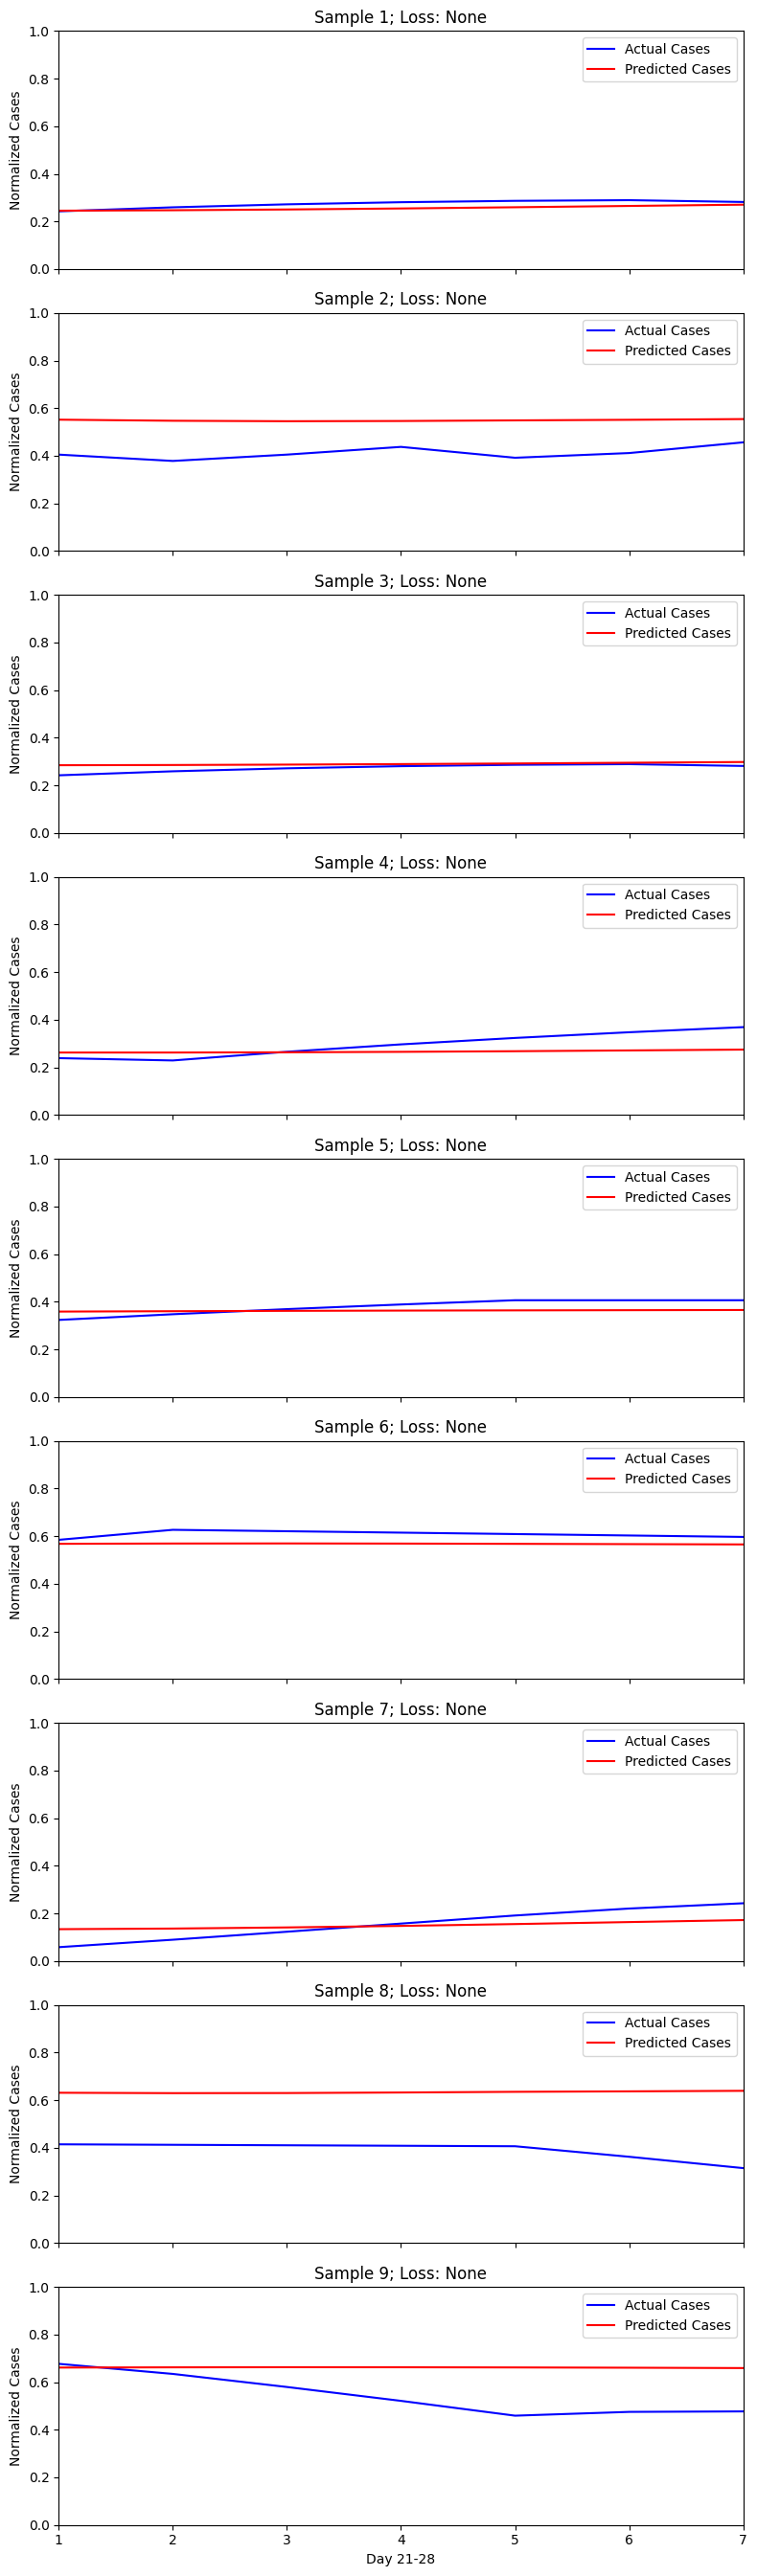

0.012837566774791089

In [ ]:
p = '/Users/jakecordery/Desktop/dissertation-york/models/architectures/E28_BS1024_IN28_LR0001_HS16_NL1.pth'
test_dl = DataLoader(DailyCaseDataset(dftest, window=35), batch_size=bs, shuffle=True, drop_last=True)
model = torch.load(p, map_location=CFG.device, weights_only=False)
test(model, test_dl, loss_fn=nn.MSELoss(), show_res=True)

In [ ]:
# Merge train, val and test sets.
dftrain = pd.read_csv('/Users/jakecordery/Desktop/dissertation-york/data/processed/TRAIN_SCALED.csv')
dfval = pd.read_csv('/Users/jakecordery/Desktop/dissertation-york/data/processed/VAL_SCALED.csv') # OVER HALF HAVE NANS.
dftest = pd.read_csv('/Users/jakecordery/Desktop/dissertation-york/data/processed/TEST_SCALED.csv')

# From the training, validation and testing sets, choose the 16 most populous counties:
# Los Angeles, CA; Cook, IL; Harris, TX; Maricopa, AZ; San Diego, CA; Orange, CA;
# Miami-Dada, FL; Dallas, TX; Kings, NY; Riverside, CA; Clark, NV; King, Washington; 
# Queens, NY; Tarrant, TX; San Bernardino, CA; Bexar, TX.

counties = ["Los Angeles County", "Harris County", "Maricopa County", "San Diego County", 
            "Orange County", "Dallas County", "Kings County", "Riverside County", 
            "Clark County", "King County", "Queens County", "Tarrant County", "San Bernardino County", "Bexar County"]
states = ["CA", "TX", "AZ", "CA", "CA", "TX", "NY", "CA", "NV", "WA", "NY", "TX", "CA", "TX"]

# Create a DataFrame filter
pairs = set(zip(counties, states))
mask_train = dftrain.apply(lambda row: (row["County Name"].strip(), row["State"]) in pairs, axis=1)
mask_val   = dfval.apply(lambda row: (row["County Name"].strip(), row["State"]) in pairs, axis=1)
mask_test  = dftest.apply(lambda row: (row["County Name"].strip(), row["State"]) in pairs, axis=1)

# Apply the filters.
dftrain_f = dftrain[mask_train].copy()
dfval_f   = dfval[mask_val].copy()
dftest_f  = dftest[mask_test].copy()

dftrain_f.reset_index(drop=True, inplace=True)
dfval_f.reset_index(drop=True, inplace=True)
dftest_f.reset_index(drop=True, inplace=True)

# Drop non-numerical columns.
non_numeric = ['Unnamed: 0', 'countyFIPS', 'County Name', 'State']
dftrain_f = dftrain_f.drop(columns=non_numeric, axis=0)
dfval_f   = dfval_f.drop(columns=non_numeric, axis=0)
dftest_f  = dftest_f.drop(columns=non_numeric, axis=0)


# Merge dataframes in order (train, val, then test).
df = pd.concat([dftrain_f, dfval_f, dftest_f], axis=1, ignore_index=True)
print(len(df))

14


In [29]:
def find_bs(p):
    pattern = r"BS(\d+)"
    match = re.search(pattern, p)
    if match:
        batch_size = int(match.group(1))
        return batch_size
    
def find_is(p):
    pattern = r"IN(\d+)"
    match = re.search(pattern, p)
    if match:
        input_size = int(match.group(1))
        return input_size 

In [31]:
def run_models(parent_folder):
    for subdir_name in os.listdir(parent_folder):
        subdir_path = os.path.join(parent_folder, subdir_name)

        # Only process directories (you could add additional filters if needed)
        if os.path.isdir(subdir_path):
            # Look for files in subdirectories with names starting with 'E20' and ending with 'pth'
            pattern = os.path.join(subdir_path, 'E20*.pth')
            for mpath in glob.glob(pattern):
                print(f"Processing file: {mpath}")
                
                # Load the model; adjust 'weights_only' based on your torch.load if needed
                model = torch.load(mpath, weights_only=False, map_location='cpu')
                print(f"Model Architecture: {model}")

                window = find_is(mpath)
                bs = find_bs(mpath)

                train_ds = DailyCaseDataset(dftrain, window=window+7)
                val_ds = DailyCaseDataset(dfval, window=window+7)

                train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=True)
                val_dl = DataLoader(val_ds, batch_size=bs, shuffle=True, drop_last=True)
                
                # Evaluate the model on training and validation data
                train_loss = test(model, train_dl, nn.MSELoss())
                test_loss = test(model, val_dl, nn.MSELoss())
                
                print(f"Train loss: {train_loss}")
                print(f"Test loss: {test_loss}")


path = "/Users/jakecordery/Desktop/dissertation-york/kaggle_ot/models/weights"
run_models(path)

Processing file: /Users/jakecordery/Desktop/dissertation-york/kaggle_ot/models/weights/LSTM10/E20_BS1024_IN21_LR0001_HS14_NL1.pth
Model Architecture: LSTM(
  (lstm): LSTM(21, 14, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=28, out_features=7, bias=True)
)
Train loss: 0.0043729962554378025
Test loss: 0.009784210922903028
Processing file: /Users/jakecordery/Desktop/dissertation-york/kaggle_ot/models/weights/LSTM11/E20_BS1024_IN21_LR0001_HS14_NL1.pth
Model Architecture: LSTM(
  (lstm): LSTM(21, 14, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=14, out_features=7, bias=True)
)
Train loss: 0.005318646842985544
Test loss: 0.012174337251304552
Processing file: /Users/jakecordery/Desktop/dissertation-york/kaggle_ot/models/weights/LSTM02/E20_BS1024_IN21_LR0001_HS6_NL1.pth
Model Architecture: LSTM(
  (lstm): LSTM(21, 6, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inpl